Conv x 8 + F.C. x 3

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [1]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader= torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [2]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        # 11 Layers : 8 conv layers and 3 fully connected layers !
        self.conv1 = nn.Conv2d(3, 8, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 12, 3,padding=1)
        self.conv3 = nn.Conv2d(12,20, 3,padding=1)
        self.conv4 = nn.Conv2d(20,24, 3,padding=1)
        self.conv5 = nn.Conv2d(24,32, 3,padding=1)
        self.conv6 = nn.Conv2d(32,48, 3,padding=1)
        self.conv7 = nn.Conv2d(48,64, 3,padding=1)
        self.conv8 = nn.Conv2d(64,72, 3,padding=1)
        self.conv9 = nn.Conv2d(72,80, 3,padding=1)
        self.fc1 = nn.Linear(80*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(F.relu(self.conv6(x)))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool(F.relu(self.conv9(x)))

        x = x.view(-1, 80*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Function to create an instance of the model on CUDA ,
# Do not use this function if you are loading a network to further train it !
# In that case just load it and call train_existing_net(model_name) !
# Infact train_existing net is almost same as new_net function with the net= Net().cuda() commented out !

def new_net(lrate,wd):
    
    net = Net().cuda()

    # net=Net()

    lossvsiter=[]

    # To see if the model is on CUDA or not !
    if (next(net.parameters()).is_cuda) :
        print("The model is on CUDA")
    else :
        print("The model is on CPU")

    # Import the optimizers 
    import torch.optim as optim

    # Declare a loss function
    criterion = nn.CrossEntropyLoss()

    # Declare an optimizer
    optimizer = optim.Adam(net.parameters(),lr=lrate,weight_decay=wd)

    #No of iterations !
    iterations = 10


    for epoch in range(iterations):  # loop over the dataset multiple times

        # Reset the loss for the current epoch !
        running_loss = 0.0

        # Loop over all the mini-batches therea are 12500 mini batches of size 4 each !
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable & if possible make them cuda tensors
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients for the current epoch
            optimizer.zero_grad()

            # forward + backward + optimize

            # forward
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Calculate gradients of whatever variable set to req_gardients = True
            loss.backward()

            # Take one step of the gradient descent for this epoch ! 
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[Epoch :: %d, Mini Batch :: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                lossvsiter.append(running_loss / 2000)
                running_loss = 0.0


    print('Finished Training')
    return lossvsiter,net

In [58]:
def unpickle(lossvsiter_curr_model):
    import pickle
    with open("./results/"+str(lossvsiter_curr_model)+".pkl","rb") as f:
        return pickle.load(f)

In [68]:
def train_existing_net(net,lossvsiter_curr_model,lrate=0.0005,wd=1e-6,iterations=5):
    
    """
    Train an existing model, continuing its progression

    Arguments :
        net : The name of the nn.Module instance being trained !
        learning rate (0.0005 by default) 
        Weight Decay (1e-6) by default
        lossvsiter_curr_model : The list containing loss of all minibatches and epoches
        iterations : The no of epochs you want to train this model for !
        
    """
    
    # Just xontinue training from last epoch

    lossvsiter=lossvsiter_curr_model
    
    start_epoch=int(2000/len(lossvsiter))
    
    print("starting from epoch no %d "%(start_epoch))

    # To see if the model is on CUDA or not !
    if (next(net.parameters()).is_cuda) :
        print("The model is on CUDA")
    else :
        print("The model is on CPU")

    # Import the optimizers 
    import torch.optim as optim

    # Declare a loss function
    criterion = nn.CrossEntropyLoss()

    # Declare an optimizer
    optimizer = optim.Adam(net.parameters(),lr=lrate,weight_decay=wd)


    for epoch in range(start_epoch,start_epoch+iterations):  # loop over the dataset multiple times

        # Reset the loss for the current epoch !
        running_loss = 0.0

        # Loop over all the mini-batches therea are 12500 mini batches of size 4 each !
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # wrap them in Variable & if possible make them cuda tensors
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients for the current epoch
            optimizer.zero_grad()

            # forward + backward + optimize

            # forward
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # Calculate gradients of whatever variable set to req_gardients = True
            loss.backward()

            # Take one step of the gradient descent for this epoch ! 
            optimizer.step()

            # print statistics
            running_loss += loss.data[0]
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[Epoch :: %d, Mini Batch :: %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                lossvsiter.append(running_loss / 2000)
                running_loss = 0.0


    print('Finished Training')
    return lossvsiter,net

In [ ]:
# Train a new modelfor || Do not run this if you want to continue from the last epoch !


loss_distribution,model=new_net(0.0005,1e-7)

The model is on CUDA
[Epoch :: 1, Mini Batch ::  2000] loss: 2.125
[Epoch :: 1, Mini Batch ::  4000] loss: 1.849
[Epoch :: 1, Mini Batch ::  6000] loss: 1.766
[Epoch :: 1, Mini Batch ::  8000] loss: 1.687
[Epoch :: 1, Mini Batch :: 10000] loss: 1.648
[Epoch :: 1, Mini Batch :: 12000] loss: 1.586
[Epoch :: 2, Mini Batch ::  2000] loss: 1.495
[Epoch :: 2, Mini Batch ::  4000] loss: 1.484
[Epoch :: 2, Mini Batch ::  6000] loss: 1.454
[Epoch :: 2, Mini Batch ::  8000] loss: 1.422
[Epoch :: 2, Mini Batch :: 10000] loss: 1.400
[Epoch :: 2, Mini Batch :: 12000] loss: 1.346
[Epoch :: 3, Mini Batch ::  2000] loss: 1.292
[Epoch :: 3, Mini Batch ::  4000] loss: 1.248
[Epoch :: 3, Mini Batch ::  6000] loss: 1.249
[Epoch :: 3, Mini Batch ::  8000] loss: 1.243
[Epoch :: 3, Mini Batch :: 10000] loss: 1.178
[Epoch :: 3, Mini Batch :: 12000] loss: 1.196
[Epoch :: 4, Mini Batch ::  2000] loss: 1.134
[Epoch :: 4, Mini Batch ::  4000] loss: 1.102
[Epoch :: 4, Mini Batch ::  6000] loss: 1.087
[Epoch :: 4, 

In [61]:
# To visualize the model !
model

Net (
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(8, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(20, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(64, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(72, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear (1280 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

In [33]:
# Helper functions to evaluate the performance of our network on test images !
"""
Arguments::
    network :: the custom nn.Module

Returns::
    accuracy_percentage
    No of correctly classified image
    
"""

def test_accuracy(model):
    correct = 0
    total = 0

    for data in testloader:
        images, labels = data
        images=images.cuda()
        labels=labels.cuda()
        try:
            outputs = model(Variable(images))
        except RuntimeError as re:
            print(outputs.is_cuda)
            print(str(re))
            sys.exit()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        accuracy_percentage= 100 * correct / total

    print('Accuracy of the network on the 10000 test images: %d  percent' % (accuracy_percentage))
    print("The network correctly predicted %d images"%(correct))
    return accuracy_percentage,correct

In [38]:
# Helper functions to evaluate the performance of our network on test images !
"""
Arguments::
    network :: the custom nn.Module

Just prints the training accuracy
    
"""

def train_accuracy(net):
    total=0
    correct=0
    for i, data in enumerate(trainloader, 0):
        images, labels = data
        images=images.cuda()
        labels=labels.cuda()
        try:
            outputs = net(Variable(images))
        except RuntimeError as re:
            print(outputs.is_cuda)
            print(str(re))
            sys.exit()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        if (i%1000) == 0:
            print("Estimattion %f percent complete "%(i/125 ))

    print('Accuracy of the network on the 50000 trained images: %f percent' % (
        100 * correct / total))

In [54]:
# Helper function to pickle "stuff"

def pickleit(stuff,name):
    import pickle
    with open("./results/"+str(name)+".pkl","wb") as f:
            pickle.dump(stuff,f)

In [34]:
test_accuracy(model)

Accuracy of the network on the 10000 test images: 71  percent
The network correctly predicted 7128 images


(71.28, 7128)

In [39]:
train_accuracy(model)

Estimattion 0.000000 percent complete 
Estimattion 8.000000 percent complete 
Estimattion 16.000000 percent complete 
Estimattion 24.000000 percent complete 
Estimattion 32.000000 percent complete 
Estimattion 40.000000 percent complete 
Estimattion 48.000000 percent complete 
Estimattion 56.000000 percent complete 
Estimattion 64.000000 percent complete 
Estimattion 72.000000 percent complete 
Estimattion 80.000000 percent complete 
Estimattion 88.000000 percent complete 
Estimattion 96.000000 percent complete 
Accuracy of the network on the 50000 trained images: 91.194000 percent


In [55]:
pickleit(model,"crazy-archi")

In [56]:
pickleit(loss_distribution,"15_epoch_loss_distribution_for_crazy_archi")

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
net=model
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    images=images.cuda()
    labels=labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 80 %
Accuracy of   car : 86 %
Accuracy of  bird : 58 %
Accuracy of   cat : 52 %
Accuracy of  deer : 65 %
Accuracy of   dog : 65 %
Accuracy of  frog : 73 %
Accuracy of horse : 72 %
Accuracy of  ship : 79 %
Accuracy of truck : 78 %


In [13]:
%matplotlib inline

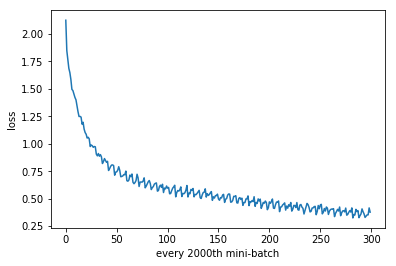

In [27]:
import matplotlib.pyplot as plt
plt.plot(loss_distribution)
plt.ylabel('loss')
plt.xlabel('every 2000th mini-batch')
plt.show()

In [57]:
# Lets save the model !!

In [28]:
torch.save(model.state_dict(),"./models/CrazyAchitecture" + str(i))

#### Now if you want to take forward the training further , just load the model and call the training function !
#### Also load the list of loss from pickled form !

In [77]:
# To see if the model is on CUDA or not !
lrate=0.0005
wd=1e-7
lossvsiter=loss_distribution
if(next(net.parameters()).is_cuda) :
    print("The model is on CUDA")
else :
    print("The model is on CPU")

# Import the optimizers 
import torch.optim as optim

# Declare a loss function
criterion = nn.CrossEntropyLoss()

# Declare an optimizer
optimizer = optim.Adam(net.parameters(),lr=lrate,weight_decay=wd)

#No of iterations !
iterations = 1


for epoch in range(iterations):  # loop over the dataset multiple times

    # Reset the loss for the current epoch !
    running_loss = 0.0

    # Loop over all the mini-batches therea are 12500 mini batches of size 4 each !
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable & if possible make them cuda tensors
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients for the current epoch
        optimizer.zero_grad()

        # forward + backward + optimize

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Calculate gradients of whatever variable set to req_gardients = True
        loss.backward()

        # Take one step of the gradient descent for this epoch ! 
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[Epoch :: %d, Mini Batch :: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            lossvsiter.append(running_loss / 2000)
            running_loss = 0.0


print('Finished Training')

The model is on CUDA
[Epoch :: 1, Mini Batch ::  2000] loss: 0.313
[Epoch :: 1, Mini Batch ::  4000] loss: 0.292
[Epoch :: 1, Mini Batch ::  6000] loss: 0.311
[Epoch :: 1, Mini Batch ::  8000] loss: 0.320
[Epoch :: 1, Mini Batch :: 10000] loss: 0.347
[Epoch :: 1, Mini Batch :: 12000] loss: 0.327
Finished Training


In [78]:
test_accuracy(model)

Accuracy of the network on the 10000 test images: 71  percent
The network correctly predicted 7118 images


(71.18, 7118)

In [79]:
train_accuracy(model)

Estimattion 0.000000 percent complete 
Estimattion 8.000000 percent complete 
Estimattion 16.000000 percent complete 
Estimattion 24.000000 percent complete 
Estimattion 32.000000 percent complete 
Estimattion 40.000000 percent complete 
Estimattion 48.000000 percent complete 
Estimattion 56.000000 percent complete 
Estimattion 64.000000 percent complete 
Estimattion 72.000000 percent complete 
Estimattion 80.000000 percent complete 
Estimattion 88.000000 percent complete 
Estimattion 96.000000 percent complete 
Accuracy of the network on the 50000 trained images: 90.288000 percent
